In [4]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
from ecco_v4_py import vector_calc, scalar_calc

import gsw
import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import matplotlib.pyplot as plt
import zarr

In [5]:
import xarray as xr
#load in data: one time slice here, can load in any xarray though
ds = xr.open_dataset('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-07_ECCO_V4r5_native_llc0090.nc')

In [6]:
ds.data_vars

Data variables:
    THETA    (time, k, tile, j, i) float32 21MB ...
    SALT     (time, k, tile, j, i) float32 21MB ...

(<Figure size 900x900 with 25 Axes>,
 array([[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]]))

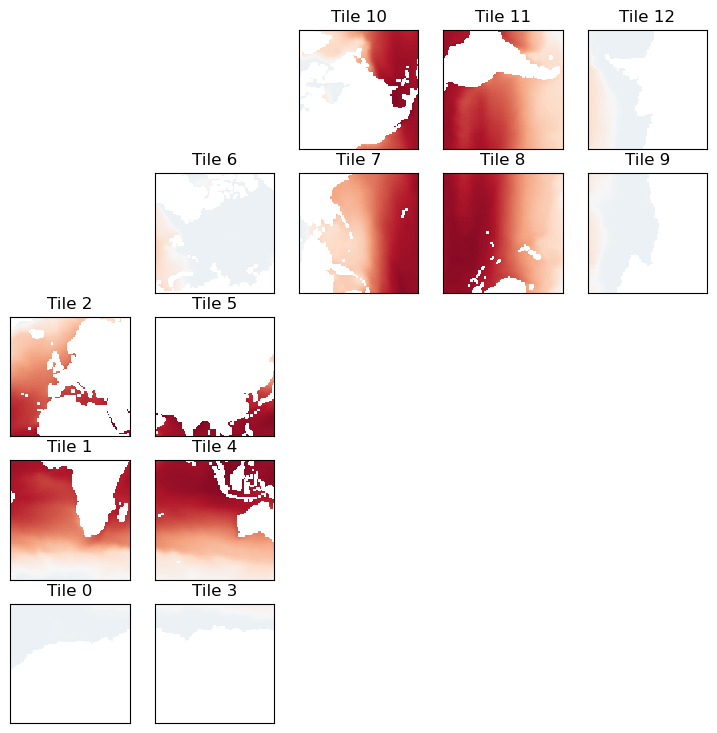

In [7]:
ecco.plot_tiles(ds['THETA'][0,0,:])

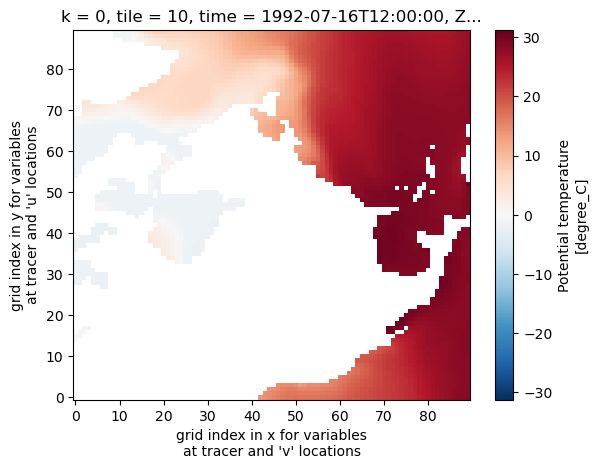

In [8]:
ds['THETA'][0,0,10].plot()

In [9]:
tile_i_care_about = ds['THETA'][0,:,10]
print(tile_i_care_about.shape)
print(tile_i_care_about.dims)
tile_i_care_about.XC[:,52].values

(50, 90, 90)
('k', 'j', 'i')


array([-127.5, -126.5, -125.5, -124.5, -123.5, -122.5, -121.5, -120.5,
       -119.5, -118.5, -117.5, -116.5, -115.5, -114.5, -113.5, -112.5,
       -111.5, -110.5, -109.5, -108.5, -107.5, -106.5, -105.5, -104.5,
       -103.5, -102.5, -101.5, -100.5,  -99.5,  -98.5,  -97.5,  -96.5,
        -95.5,  -94.5,  -93.5,  -92.5,  -91.5,  -90.5,  -89.5,  -88.5,
        -87.5,  -86.5,  -85.5,  -84.5,  -83.5,  -82.5,  -81.5,  -80.5,
        -79.5,  -78.5,  -77.5,  -76.5,  -75.5,  -74.5,  -73.5,  -72.5,
        -71.5,  -70.5,  -69.5,  -68.5,  -67.5,  -66.5,  -65.5,  -64.5,
        -63.5,  -62.5,  -61.5,  -60.5,  -59.5,  -58.5,  -57.5,  -56.5,
        -55.5,  -54.5,  -53.5,  -52.5,  -51.5,  -50.5,  -49.5,  -48.5,
        -47.5,  -46.5,  -45.5,  -44.5,  -43.5,  -42.5,  -41.5,  -40.5,
        -39.5,  -38.5], dtype=float32)

In [10]:
face_of_t_that_i_care_about = tile_i_care_about[:,:,52]
face_of_t_that_i_care_about

<xarray.DataArray 'THETA' (k: 50, j: 90)> Size: 18kB
[4500 values with dtype=float32]
Coordinates:
    i        int32 4B 52
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    tile     int32 4B 10
    time     datetime64[ns] 8B 1992-07-16T12:00:00
    XC       (j) float32 360B ...
    YC       (j) float32 360B ...
    Z        (k) float32 200B ...
Attributes:
    valid_min:              -2.7571568
    valid_max:              33.054157
    coverage_content_type:  modelResult
    long_name:              Potential temperature 
    standard_name:          sea_water_potential_temperature
    units:                  degree_C
    comment:                Sea water potential temperature is the temperatur...

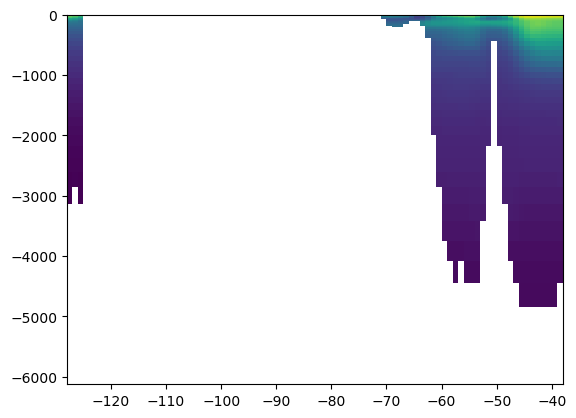

In [12]:
#plot single tile
plt.pcolormesh(face_of_t_that_i_care_about.XC, face_of_t_that_i_care_about.Z, face_of_t_that_i_care_about)

In [17]:
#now try with all faces for surface
nlon_centers, nlat_centers, nlone, nlate, T_reg = \
    ecco.resample_to_latlon(ds.XC, ds.YC, 
                            ds['THETA'][0][0], -90, 90,
                            0.2, -180, 180, 0.2, 
                            radius_of_influence=200000.0,
                            mapping_method='nearest_neighbor')

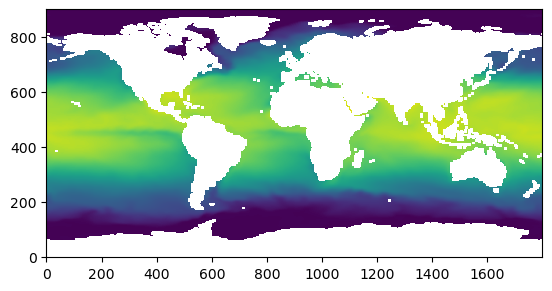

In [15]:
plt.imshow(T_reg, origin='lower')

In [19]:
#now all depth
T_latlon_beast = []
for k in range(50):
    nlon_centers, nlat_centers, nlone, nlate, T_reg = \
        ecco.resample_to_latlon(ds.XC, ds.YC, 
                                ds['THETA'][0][k], -90, 90,
                                0.2, -180, 180, 0.2, 
                                radius_of_influence=200000.0,
                                mapping_method='nearest_neighbor')
    T_latlon_beast.append(T_reg)

In [20]:
j_tokyo = np.argmax(nlat_centers[:,0] >= 36.5)
nlat_centers[j_tokyo,0]
print(f'find godzilla at ', j_tokyo)

find godzilla at  632


In [21]:
T_latlon_beast = np.array(T_latlon_beast)
T_latlon_beast

array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.9453455, -1.9453455, -1.9453455, ..., -1.9453455,
         -1.9453455, -1.9453455],
        [-1.9459356, -1.9459356, -1.9459356, ..., -1.9459356,
         -1.9459356, -1.9459356],
        [-1.9459356, -1.9459356, -1.9459356, ..., -1.9459356,
         -1.9459356, -1.9459356]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.9398398, -1.9398398, -1.9398398, ..., -1.9398398,
         -1.9398398, -1.9398398],
        [-1.

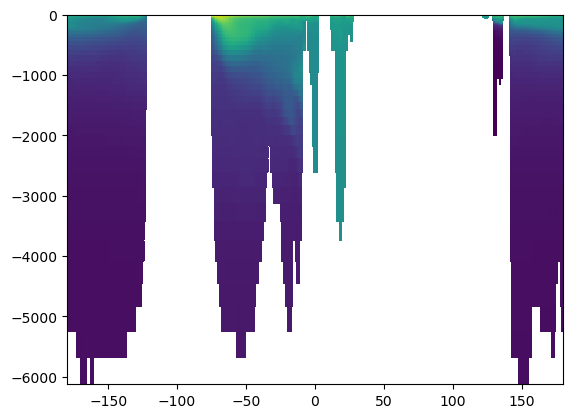

In [22]:
plt.pcolor(nlon_centers[0,:], ds.Z, T_latlon_beast[:, j_tokyo,:])